In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import pandas as pd
import numpy as np
import torch as th
import nltk

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
device = th.device("cuda")
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#path = "/content/drive/MyDrive/lemma_tokenizeddf.csv"
path = "/dataframes/lemma_tokenizeddf.csv"
data = pd.read_csv(path)
data

FileNotFoundError: ignored

Distribution of Yelp reviews by star rating is heavily skewed: there are many 5-star and 1-star reviews, and comparatively fewer 2, 3, and 4-star reviews.

Use data augmentation to generate new reviews for underrepresented star ratings based on reviews w/ slight perturbations. This balances class labels for dataset + achieves more even proportion of reviews across star ratings.

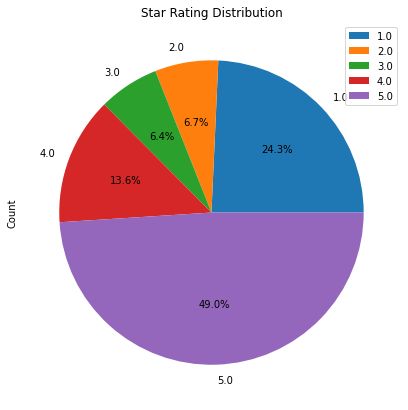

In [ ]:
# Visualize distribution of star ratings
new_df = data.groupby(['stars']).count()[['Unnamed: 0']].rename(columns = {'Unnamed: 0': 'Count'})
new_df.plot.pie(y = 'Count', autopct='%1.1f%%', figsize = (7,7), title = 'Star Rating Distribution')

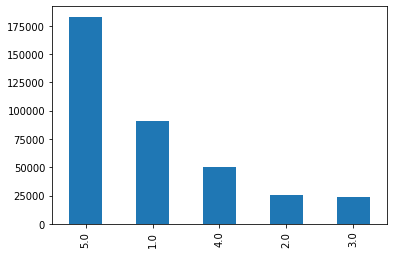

In [ ]:
data['stars'].value_counts().plot(kind='bar')

In [ ]:
# subset of reviews to augment
new_data = data[data.stars.isin([2.0, 3.0, 4.0])]

**EDA: Easy Data Augmentation**

https://towardsdatascience.com/these-are-the-easiest-data-augmentation-techniques-in-natural-language-processing-you-can-think-of-88e393fd610

original paper: https://arxiv.org/abs/1901.11196

1.   synonym replacement
2.   random swap
3.   random deletion
4.   random insertion



In [ ]:
!pip install nlpaug
!pip install transformers

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

     |████████████████████████████████| 2.1MB 18.0MB/s 
     |████████████████████████████████| 901kB 53.5MB/s 
     |████████████████████████████████| 3.3MB 55.9MB/s 


In [ ]:
# example review
text = new_data['text'].values[2]
text

"The food was over cooked and expensive, especially the chicken. The flavours were nothing special and the fries were soggy. The kid's mac and cheese was slimy and lacked any flavour as well. The corn bread was okay, but how hard is that?"

**Synonym Replacement**

*Substitute word by contextual word embeddings using RoBERTA model.*

In [ ]:
replace_aug = naw.ContextualWordEmbsAug(
    model_path='roberta-base', action="substitute", aug_p = 0.6)
augmented_text = replace_aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)


Original:
The food was over cooked and expensive, especially the chicken. The flavours were nothing special and the fries were soggy. The kid's mac and cheese was slimy and lacked any flavour as well. The corn bread was okay, but how hard is that?
Augmented Text:
The food was over cooked and expensive, especially its fries. The potatoes were really special and the fries quite soggy. The cheese spinach and cheese was slimy and lacked any flavour as well. Regular corn bread was okay, but how hard works heaven?


**Random Swap**

In [ ]:
swap_aug = naw.RandomWordAug(action="swap")
augmented_text = swap_aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The food was over cooked and expensive, especially the chicken. The flavours were nothing special and the fries were soggy. The kid's mac and cheese was slimy and lacked any flavour as well. The corn bread was okay, but how hard is that?
Augmented Text:
Food the over was cooked expensive and, the especially chicken. The flavours nothing were special and the fries were soggy. The kid ' and s mac cheese was slimy and lacked any flavour well as. The corn was bread, okay but how hard is that?


**Random Deletion**

In [ ]:
delete_aug = naw.RandomWordAug()
augmented_text = delete_aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The food was over cooked and expensive, especially the chicken. The flavours were nothing special and the fries were soggy. The kid's mac and cheese was slimy and lacked any flavour as well. The corn bread was okay, but how hard is that?
Augmented Text:
The food over cooked expensive, especially the chicken. The flavours were and the fries were soggy. The kid ' and cheese and lacked any flavour as well. The corn bread, but how hard is that?


**Random Insertion**

In [ ]:
insert_aug = naw.ContextualWordEmbsAug(
    model_path='roberta-base', action="insert")
augmented_text = insert_aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The food was over cooked and expensive, especially the chicken. The flavours were nothing special and the fries were soggy. The kid's mac and cheese was slimy and lacked any flavour as well. The corn bread was okay, but how hard is that?
Augmented Text:
The food was really over cooked and expensive, especially the jerk chicken. -- The flavours were nothing special and the fries were soggy.... The kid's mac and cream cheese was slimy and lacked any flavour as well. The corn - bread was okay, well but look how incredibly hard made is that?


**Perform EDA techniques sequentially:**

In [ ]:
sequential_aug = naf.Sequential([delete_aug, insert_aug, replace_aug, swap_aug])
augmented_text = sequential_aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The food was over cooked and expensive, especially the chicken. The flavours were nothing special and the fries were soggy. The kid's mac and cheese was slimy and lacked any flavour as well. The corn bread was okay, but how hard is that?
Augmented Text:
Food the itself was over expensive cooked and, especially chicken. fries My were special nothing more then overall the sides also were bad. - - <unk> kid s ' n s stuffed mac and was enough slimy lacked character any. The chicken corn okay, tasty maybe?


In [ ]:
# augment 2-star reviews + write to output file
two_star = data[data.stars.isin([2.0])]['text'].values

for text in two_star:
  augmented_text = sequential_aug.augment(text)

  with open('two_stars.csv', mode='a') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow([augmented_text])

Token indices sequence length is longer than the specified maximum sequence length for this model (642 > 512). Running this sequence through the model will result in indexing errors


Created 1550 augmented 2-star reviews w/ EDA techniques (about 7% of original # of reviews)